# Verification experiment - NARMAX


I generate data according to a NARMAX model and recover parameters using both a FEM estimator and an RLS estimator. The estimators are validated with a simulation error experiment.

In [1]:
using Revise
using ProgressMeter
using LinearAlgebra
using Plots
pyplot();

## Data generation

In [2]:
# Orders
deg = 1
M1 = 3
M2 = 2
M3 = 4
# M = (M1+1+M2+M3)*deg + 1
M = M1+1+M2+M3

# Parameters
τ_true = 1e4
θ_true = .2 .*randn(M,)
θ_true[end] = 0.

# Time horizon
T = 10000

# Nonlinearity
# P = zeros(M,1); for d=1:degree; P = hcat(d .*Matrix{Float64}(I,M,M), P); end
# ϕ(x::Array{Float64,1}) = [prod(x.^P[:,k]) for k = 1:size(P,2)]
ϕ(x::Array{Float64,1}) = x

# Input frequency and amplitude
ω = 1/(2*π)
A = range(0.1, stop=2.0, length=T)

# Observation array
input = zeros(T,)
output = zeros(T,)
errors = zeros(T,)

# First outputs
output[1:M1] .= 0.0

for k = 1:T
    
    # Input
    input[k] = A[k]*cos(ω*k)
    
    # Generate noise
    errors[k] = sqrt(inv(τ_true))*randn(1)[1]
   
    # Output
    if k < M
        output[k] = input[k] + errors[k]
    else
        # Update history vectors
        x_kmin1 = output[k-1:-1:max(1,k-M1)]
        z_kmin1 = input[k-1:-1:max(1,k-M2)]
        r_kmin1 = errors[k-1:-1:max(1,k-M3)]
        
        # Compute output
        output[k] = θ_true'*ϕ([x_kmin1; input[k]; z_kmin1; r_kmin1]) + errors[k]
    end
end

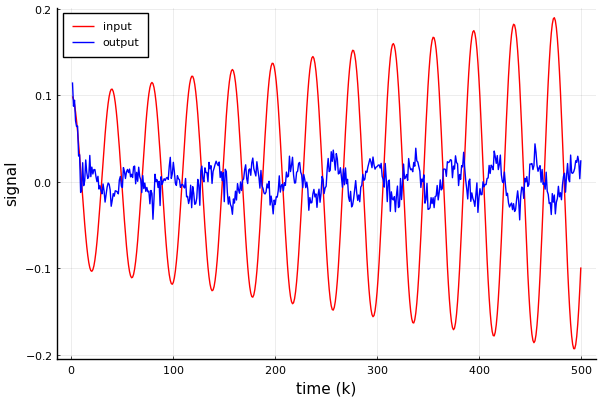

In [3]:
if T > 500
    plot(1:500, input[1:500], color="red", label="input", xlabel="time (k)", ylabel="signal")
    plot!(1:500, output[1:500], color="blue", label="output", xlabel="time (k)", ylabel="signal")
else
    tt = 1
    plot(1:tt:T, input[1:tt:T], color="red", label="input", xlabel="time (k)", ylabel="signal")
    plot!(1:tt:T, output[1:tt:T], color="blue", label="output", xlabel="time (k)", ylabel="signal")
end

Split into training and validation sets.

In [4]:
# Select training set
ix_trn = Array{Int64,1}(100:8000)
input_trn = input[ix_trn]
output_trn = output[ix_trn]
T_trn = length(ix_trn);

# Select validation set
ix_val = Array{Int64,1}(8001:T)
input_val = input[ix_val]
output_val = output[ix_val]
T_val = length(ix_val);

## Inference

In [5]:
using ForneyLab
import ForneyLab: unsafeMean, unsafeCov, unsafeMeanCov

In [6]:
using NARMAX

In [7]:
graph = FactorGraph()

# Observed variables
@RV x_kmin1; placeholder(x_kmin1, :x_kmin1, dims=(M1,))
@RV z_kmin1; placeholder(z_kmin1, :z_kmin1, dims=(M2,))
@RV r_kmin1; placeholder(r_kmin1, :r_kmin1, dims=(M3,))
@RV u_k; placeholder(u_k, :u_k)

# Time-invariant parameters
@RV θ ~ GaussianMeanVariance(placeholder(:m_θ, dims=(M,)), placeholder(:v_θ, dims=(M, M)))
@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))

# Likel7ihood
@RV y_k ~ NAutoRegressiveMovingAverageX(θ, x_kmin1, u_k, z_kmin1, r_kmin1, τ, g=ϕ)
placeholder(y_k, :y_k)

ForneyLab.draw(graph)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 16496448096563891674 -->
 
 16496448096563891674 
 
 NARMAX 
 nautoregressivemovingaveragex_1 
 
<!-- 9878307966883709059 -->
 
 9878307966883709059 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 16496448096563891674--9878307966883709059 -->
 
 16496448096563891674--9878307966883709059 
 
 θ 
 1 out 
 2 θ 
 
<!-- 8505558701279212245 -->
 
 8505558701279212245 
 
 placeholder_x_kmin1 
 
<!-- 16496448096563891674--8505558701279212245 -->
 
 16496448096563891674--8505558701279212245 
 
 x_kmin1 
 1 out 
 3 x 
 
<!-- 10884740621078919884 -->
 
 10884740621078919884 
 
 placeholder_z_kmin1 
 
<!-- 16496448096563891674--10884740621078919884 -->
 
 16496448096563891674--10884740621078919884 
 
 z_kmin1 
 1 out 
 5 z 
 
<!-- 7007203146833044849 -->
 
 7007203146833044849 
 
 placeholder_u_k 
 
<!-- 16496448096563891674--7007203146833044849 -->
 
 16496448096563891674--7007203146833044849 
 
 u_k 
 1 out 
 4 u 
 
<!-- 13550018051836186555 -->
 
 13550018051836186555 
 
 Gam 
 gamma_1 
 
<!-- 16496448096563891674--13550018051836186555 -->
 
 16496448096563891674--13550018051836186555 
 
 τ 
 1 out 
 7 τ 
 
<!-- 2367931081732714616 -->
 
 2367931081732714616 
 
 placeholder_r_kmin1 
 
<!-- 16496448096563891674--2367931081732714616 -->
 
 16496448096563891674--2367931081732714616 
 
 r_kmin1 
 1 out 
 6 r 
 
<!-- 18144863609203616343 -->
 
 18144863609203616343 
 
 placeholder_m_θ 
 
<!-- 9878307966883709059--18144863609203616343 -->
 
 9878307966883709059--18144863609203616343 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 14773606348792352764 -->
 
 14773606348792352764 
 
 placeholder_v_θ 
 
<!-- 9878307966883709059--14773606348792352764 -->
 
 9878307966883709059--14773606348792352764 
 
 v_θ 
 1 out 
 3 v 
 
<!-- 798615550961171934 -->
 
 798615550961171934 
 
 placeholder_a_τ 
 
<!-- 13550018051836186555--798615550961171934 -->
 
 13550018051836186555--798615550961171934 
 
 a_τ 
 1 out 
 2 a 
 
<!-- 6441955830366922208 -->
 
 6441955830366922208 
 
 placeholder_b_τ 
 
<!-- 13550018051836186555--6441955830366922208 -->
 
 13550018051836186555--6441955830366922208 
 
 b_τ 
 1 out 
 3 b 
 
<!-- 6136090346255335221 -->
 
 6136090346255335221 
 
 placeholder_y_k 
 
<!-- 6136090346255335221--16496448096563891674 -->
 
 6136090346255335221--16496448096563891674 
 
 y_k 
 1 y 
 1 out

In [8]:
q = PosteriorFactorization(θ, τ, ids=[:θ :τ])
algorithm = messagePassingAlgorithm([θ; τ], q)
source_code = algorithmSourceCode(algorithm)
eval(Meta.parse(source_code));

In [9]:
# Preallocate parameter arrays
params_θ = (zeros(T_trn,M), zeros(T_trn,M,M))
params_τ = (zeros(T_trn,1), zeros(T_trn,1))

# Initialize priors
θ_k = (.2 .*ones(M,), 10 .*Matrix{Float64}(I, M, M))
τ_k = (1e4, 1e0)

# Initialize marginals
marginals = Dict(:θ => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=θ_k[1], v=θ_k[2]),
                 :τ => ProbabilityDistribution(Univariate, Gamma, a=τ_k[1], b=τ_k[2]))

# Keep track of residuals
predictions = (zeros(T,), zeros(T,))
residuals = zeros(T,)

@showprogress for k in ix_trn
    
    # Update history vectors
    x_kmin1 = output[k-1:-1:k-M1]
    z_kmin1 = input[k-1:-1:k-M2]
    r_kmin1 = residuals[k-1:-1:k-M3]
    ϕx = ϕ([x_kmin1; input[k]; z_kmin1; r_kmin1])
    
    # Predictions
    predictions[1][k] = θ_k[1]'*ϕx
    predictions[2][k] = ϕx'*θ_k[2]'*ϕx
    
    # Compute prediction error
    residuals[k] = output[k] - predictions[1][k]
    
    # Set data 
    data = Dict(:y_k => output[k],
                :u_k => input[k],
                :x_kmin1 => x_kmin1,
                :z_kmin1 => z_kmin1,
                :r_kmin1 => r_kmin1,
                :m_θ => θ_k[1],
                :v_θ => θ_k[2],
                :a_τ => τ_k[1],
                :b_τ => τ_k[2])
    
    # Iterate updates
    for n = 1:10
        stepθ!(data, marginals)
        stepτ!(data, marginals)
    end    
    
    # Update params
    θ_k = (unsafeMean(marginals[:θ]), unsafeCov(marginals[:θ]))
    τ_k = (marginals[:τ].params[:a], marginals[:τ].params[:b])
    
    # Store params
    params_θ[1][k-ix_trn[1]+1,:] = θ_k[1]
    params_θ[2][k-ix_trn[1]+1,:,:] = θ_k[2]
    params_τ[1][k-ix_trn[1]+1] = τ_k[1]
    params_τ[2][k-ix_trn[1]+1] = τ_k[2]
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


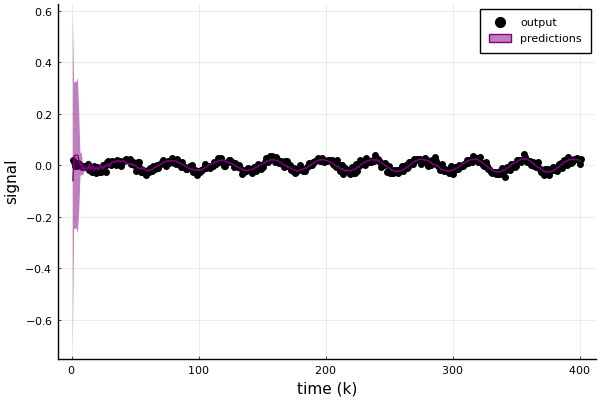

In [10]:
if T > 500
    scatter(output[ix_trn[1]:500], color="black", label="output", xlabel="time (k)", ylabel="signal")
    plot!(predictions[1][ix_trn[1]:500], ribbon=[sqrt.(predictions[2][ix_trn[1]:end]), sqrt.(predictions[2][ix_trn[1]:end])], color="purple", label="predictions")
else
    tt = 10
    scatter(output[ix_trn[1]:tt:ix_trn[end]], color="black", label="output", xlabel="time (k)", ylabel="signal")
    plot!(predictions[1][ix_trn[1]:tt:ix_trn[end]], ribbon=[sqrt.(predictions[2][ix_trn[1]:tt:ix_trn[end]]), sqrt.(predictions[2][ix_trn[1]:tt:ix_trn[end]])], color="purple", label="predictions")
end

## Simulation

In [11]:
graph2 = FactorGraph()

# Observed variables
@RV x_kmin1; placeholder(x_kmin1, :x_kmin1, dims=(M1,))
@RV z_kmin1; placeholder(z_kmin1, :z_kmin1, dims=(M2,))
@RV r_kmin1; placeholder(r_kmin1, :r_kmin1, dims=(M3,))
@RV u_k; placeholder(u_k, :u_k)

# Time-invariant parameters
@RV θ; placeholder(θ, :θ, dims=(M,))
@RV τ; placeholder(τ, :τ)

# Likelihood
@RV y_k ~ NAutoRegressiveMovingAverageX(θ, x_kmin1, u_k, z_kmin1, r_kmin1, τ, g=ϕ)

ForneyLab.draw(graph2)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 10096503515817940435 -->
 
 10096503515817940435 
 
 placeholder_z_kmin1 
 
<!-- 1311376460148733443 -->
 
 1311376460148733443 
 
 placeholder_x_kmin1 
 
<!-- 8756179245146577486 -->
 
 8756179245146577486 
 
 placeholder_u_k 
 
<!-- 3538741361963259922 -->
 
 3538741361963259922 
 
 placeholder_τ 
 
<!-- 15967410918913041089 -->
 
 15967410918913041089 
 
 NARMAX 
 nautoregressivemovingaveragex_1 
 
<!-- 15967410918913041089--10096503515817940435 -->
 
 15967410918913041089--10096503515817940435 
 
 z_kmin1 
 1 out 
 5 z 
 
<!-- 15967410918913041089--1311376460148733443 -->
 
 15967410918913041089--1311376460148733443 
 
 x_kmin1 
 1 out 
 3 x 
 
<!-- 15967410918913041089--8756179245146577486 -->
 
 15967410918913041089--8756179245146577486 
 
 u_k 
 1 out 
 4 u 
 
<!-- 15967410918913041089--3538741361963259922 -->
 
 15967410918913041089--3538741361963259922 
 
 τ 
 1 out 
 7 τ 
 
<!-- 761256658263742276 -->
 
 761256658263742276 
 
 placeholder_θ 
 
<!-- 15967410918913041089--761256658263742276 -->
 
 15967410918913041089--761256658263742276 
 
 θ 
 1 out 
 2 θ 
 
<!-- 12670681327524266704 -->
 
 12670681327524266704 
 
 placeholder_r_kmin1 
 
<!-- 15967410918913041089--12670681327524266704 -->
 
 15967410918913041089--12670681327524266704 
 
 r_kmin1 
 1 out 
 6 r 
 
<!-- 97699629541895850732 -->
 
 97699629541895850732 
 
<!-- 97699629541895850732--15967410918913041089 -->
 
 97699629541895850732--15967410918913041089 
 
 y_k 
 1 y

In [12]:
q = PosteriorFactorization(y_k, ids=[:y_k])
algorithm = messagePassingAlgorithm()
source_code = algorithmSourceCode(algorithm)
eval(Meta.parse(source_code));

In [13]:
marginals = Dict(:y_k => vague(GaussianMeanPrecision))

@showprogress for k in ix_val
    
    # Update history vectors
    x_kmin1 = predictions[1][k-1:-1:k-M1]
    z_kmin1 = input[k-1:-1:k-M2]
    r_kmin1 = zeros(M3,)
    
    # Set data 
    data = Dict(:u_k => input[k],
                :x_kmin1 => x_kmin1,
                :z_kmin1 => z_kmin1,
                :r_kmin1 => r_kmin1,
                :τ => τ_k[1]/τ_k[2],
                :θ => θ_k[1])
    
    # Iterate updates
    stepy_k!(data, marginals)
    
    # Store params
    predictions[1][k] = unsafeMean(marginals[:y_k])
    predictions[2][k] = unsafeCov(marginals[:y_k])
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


## Visualization

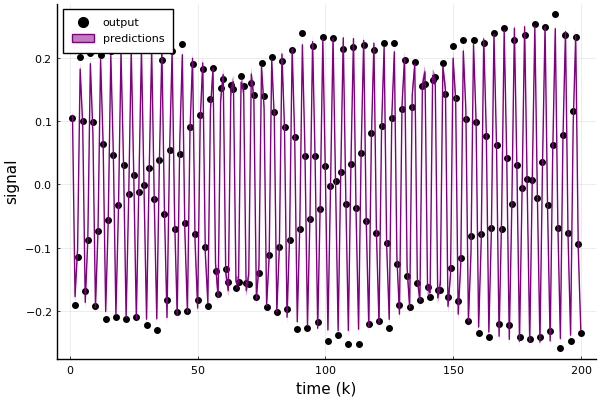

In [14]:
tt = 10
scatter(output[ix_val[1]:tt:ix_val[end]], color="black", label="output", xlabel="time (k)", ylabel="signal")
plot!(predictions[1][ix_val[1]:tt:ix_val[end]], ribbon=[sqrt.(predictions[2][ix_val[1]:tt:ix_val[end]]), sqrt.(predictions[2][ix_val[1]:tt:ix_val[end]])], color="purple", label="predictions")

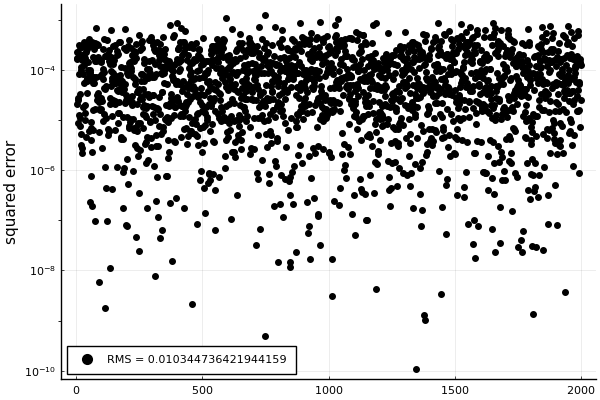

In [15]:
error_FEM = predictions[1][ix_val] - output[ix_val]
RMS_FEM = sqrt(mean(error_FEM.^2))

scatter(error_FEM.^2, label="RMS = "*string(RMS_FEM), color="black", ylabel="squared error", yscale=:log10)

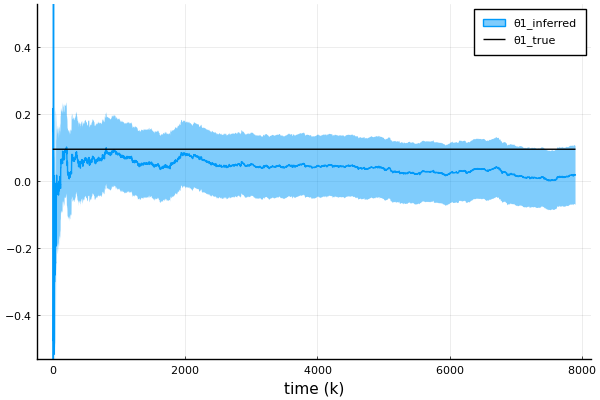

In [16]:
plot(params_θ[1][:,1], ribbon=[sqrt.(params_θ[2][:,1,1]) sqrt.(params_θ[2][:,1,1])], xlabel="time (k)", label="θ1_inferred")
plot!(θ_true[1]*ones(T_trn,), color="black", label="θ1_true", ylims=[-.5, .5])

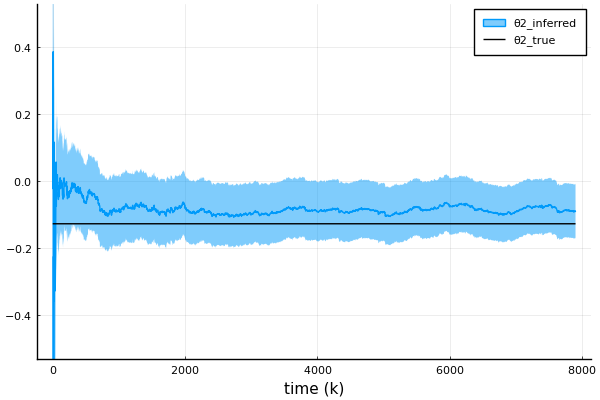

In [17]:
plot(params_θ[1][:,2], ribbon=[sqrt.(params_θ[2][:,2,2]) sqrt.(params_θ[2][:,2,2])], xlabel="time (k)", label="θ2_inferred")
plot!(θ_true[2]*ones(T_trn,), color="black", label="θ2_true", ylims=[-.5, .5])

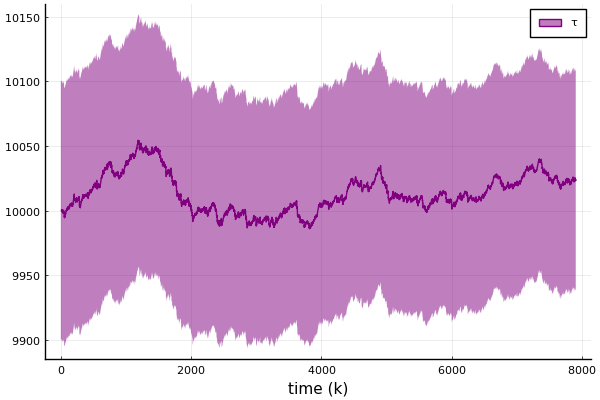

In [18]:
mτ = params_τ[1] ./ params_τ[2]
vτ = params_τ[1] ./ params_τ[2].^2

plot(mτ, ribbon=[sqrt.(vτ) sqrt.(vτ)], color="purple", xlabel="time (k)", label="τ")

## Baseline: RLS

Recursive least-squares filter ([wiki](https://en.wikipedia.org/wiki/Recursive_least_squares_filter#Recursive_algorithm)).

In [19]:
# Parameters
M = 1 + M2 + M1
λ = 1.00
w = zeros(M,)
P = λ.*Matrix{Float64}(I,M,M)

# Track weights
w_k = zeros(M,T);

# Preallocate prediction array
predictions_RLS = zeros(T,)

for k in ix_trn
    
    # Update data vector
    x = [output[k-1:-1:k-M1]; input[k:-1:k-M2]]
#     x_k = input[k:-1:k-M2]
    
    # Update weights
    α = output[k] - w'*x
    g = P*x*inv(λ + x'*P*x)
    P = inv(λ)*P - g*x'*inv(λ)*P
    w = w + α*g
    
    # Prediction
    predictions_RLS[k] = w'*x
    
    # Store weights
    w_k[:,k] = w
end

In [20]:
# Simulation
for k in ix_val
    
    # Update data vector
    x = [predictions_RLS[k-1:-1:k-M1]; input[k:-1:k-M2]]
    
    # Prediction
    predictions_RLS[k] = w'*x
    
end

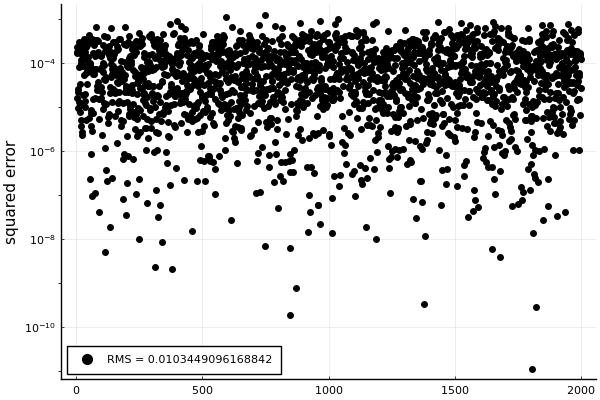

In [21]:
error_RLS = predictions_RLS[ix_val] - output[ix_val]
RMS_RLS = sqrt(mean(error_RLS.^2))

scatter(error_RLS.^2, label="RMS = "*string(RMS_RLS), color="black", ylabel="squared error", yscale=:log10)

## Comparison

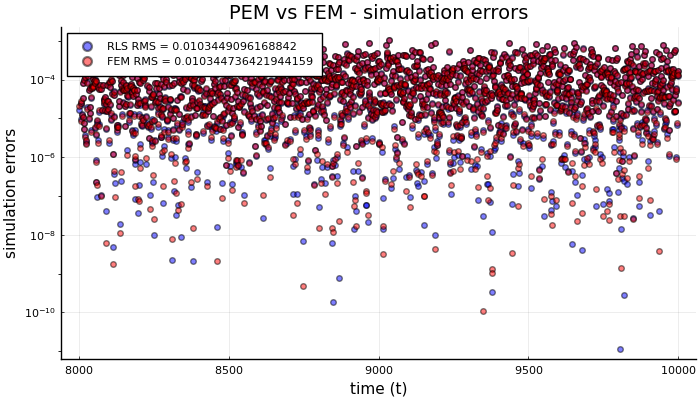

In [22]:
# Comparing simulation errors between PEM and FEM
scatter(ix_val, 
        error_RLS.^2, 
        color="blue", 
        alpha=0.5,
        markersize=4, 
        size=(700,400), 
        yscale=:log10,
        xlabel="time (t)", 
        ylabel="simulation errors",
        label="RLS RMS = "*string(RMS_RLS),
        legend=:topleft)
scatter!(ix_val, 
         error_FEM.^2, 
         color="red", 
         alpha=0.5,
         markersize=4,
         labels="FEM RMS = "*string(RMS_FEM),
         title="PEM vs FEM - simulation errors")